In [1]:
%load_ext autoreload
%autoreload 2

import os
if os.getcwd() == '/home/jovyan/work': # jhub
    os.chdir("24FS_I4DS27/main/") 
    os.system("make reqs")
else: # local
    os.chdir("../")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.figsize"] = (16, 8)

pd.set_option("future.no_silent_downcasting", True)

In [3]:
# read in the results
results = defaultdict(list)
for folder in [item for item in os.listdir("robustified_models") if os.path.isdir(f"robustified_models/{item}")]:

    folder_split = folder.split("-")
    model = f"{folder_split[0]}-{folder_split[1]}-{folder_split[2]}"
    i = folder_split[3].split("_")[1]

    for subfolder in os.listdir(f"robustified_models/{folder}"):
        if subfolder == "01_UAPs_pre_robustification":
            if os.path.exists(f"robustified_models/{folder}/{subfolder}/UAPs_tensor.pt"):
                csv_file = f"robustified_models/{folder}/{subfolder}/metrics.csv"
                metrics_df = pd.read_csv(csv_file)
                uap_time_elapsed = metrics_df["uap_time_elapsed"].dropna()
                results[(model, i, subfolder, "uap_time_elapsed", "mean")] = uap_time_elapsed.mean()
                results[(model, i, subfolder, "uap_time_elapsed", "sem")] = uap_time_elapsed.sem()
            else:
                results[(model, i, subfolder, "uap_time_elapsed", "mean")] = np.inf
                results[(model, i, subfolder, "uap_time_elapsed", "sem")] = np.inf

        if subfolder.startswith(("02", "03", "05", "06")):
            csv_file = f"robustified_models/{folder}/{subfolder}/metrics.csv"
            metrics_df = pd.read_csv(csv_file).iloc[:, 2:]
            for col in metrics_df.columns:
                results[(model, i, subfolder, col, None)] = metrics_df.loc[:, col].values[0]

        if subfolder.startswith(("03", "06")):
            predictions_type = "test" if "test" in subfolder else "val"
            no_perturbations_foldername = (
                f"02_eval_unrobustified_{predictions_type}" if subfolder.startswith("03") else f"05_eval_robustified_{predictions_type}"
            )
            predictions_UAP_df = pd.read_csv(f"robustified_models/{folder}/{subfolder}/{predictions_type}_predictions.csv")
            predictions_df = pd.read_csv(
                f"robustified_models/{folder}/{no_perturbations_foldername}/{predictions_type}_predictions.csv"
            )

            results[(model, i, subfolder, "fooling_rate", None)] = (
                predictions_UAP_df.predictions.round() != predictions_df.predictions.round()
            ).mean()
            # results[(model, i, subfolder, "predictions", None)] = list(predictions_df.iloc[:, 1].values)
            # results[(model, i, subfolder, "targets", None)] = list(predictions_df.iloc[:, 2].values.astype(int))

        if subfolder.startswith("04"):
            csv_file = f"robustified_models/{folder}/{subfolder}/metrics.csv"
            metrics_df = pd.read_csv(csv_file).iloc[:, 9:]
            for col in metrics_df.columns:
                results[(model, i, subfolder, col, None)] = metrics_df.loc[:, col].dropna().values

df_results = pd.DataFrame.from_dict(
    results,
    orient="index",
    columns=["value"],
)
df_results.index = pd.MultiIndex.from_tuples(
    df_results.index,
    names=["model", "robustification", "stage", "metric", "agg"],
)
df_results = df_results.sort_values(
    by=["model", "robustification", "stage", "metric", "agg"],
)
df_results = df_results.reset_index()

In [4]:
fooling_rates = df_results[df_results["metric"] == "fooling_rate"].sort_values(
    by=["robustification", "stage"], ascending=True
)

fooling_rates_unrobustified = (
    fooling_rates[fooling_rates["stage"].str.startswith("03")]
    .groupby(["model", "robustification"])["value"]
    .agg(["mean", "sem"])
    .melt(ignore_index=False, var_name="agg").pivot_table(
        index="model", columns=["robustification","agg"], values=["value"]
    )
)
fooling_rates_unrobustified_mean = fooling_rates_unrobustified.xs("mean", axis=1, level=2).droplevel(0, axis=1)
fooling_rates_unrobustified_sem = fooling_rates_unrobustified.xs("sem", axis=1, level=2).droplevel(0, axis=1)

fooling_rates_robustified = (
    fooling_rates[fooling_rates["stage"].str.startswith("06")]
    .groupby(["model", "robustification"])["value"]
    .agg(["mean", "sem"])
    .melt(ignore_index=False, var_name="agg").pivot_table(
        index="model", columns=["robustification","agg"], values=["value"]
    )
)

fooling_rates_robustified_mean = fooling_rates_robustified.xs("mean", axis=1, level=2).droplevel(0, axis=1)
fooling_rates_robustified_sem = fooling_rates_robustified.xs("sem", axis=1, level=2).droplevel(0, axis=1)

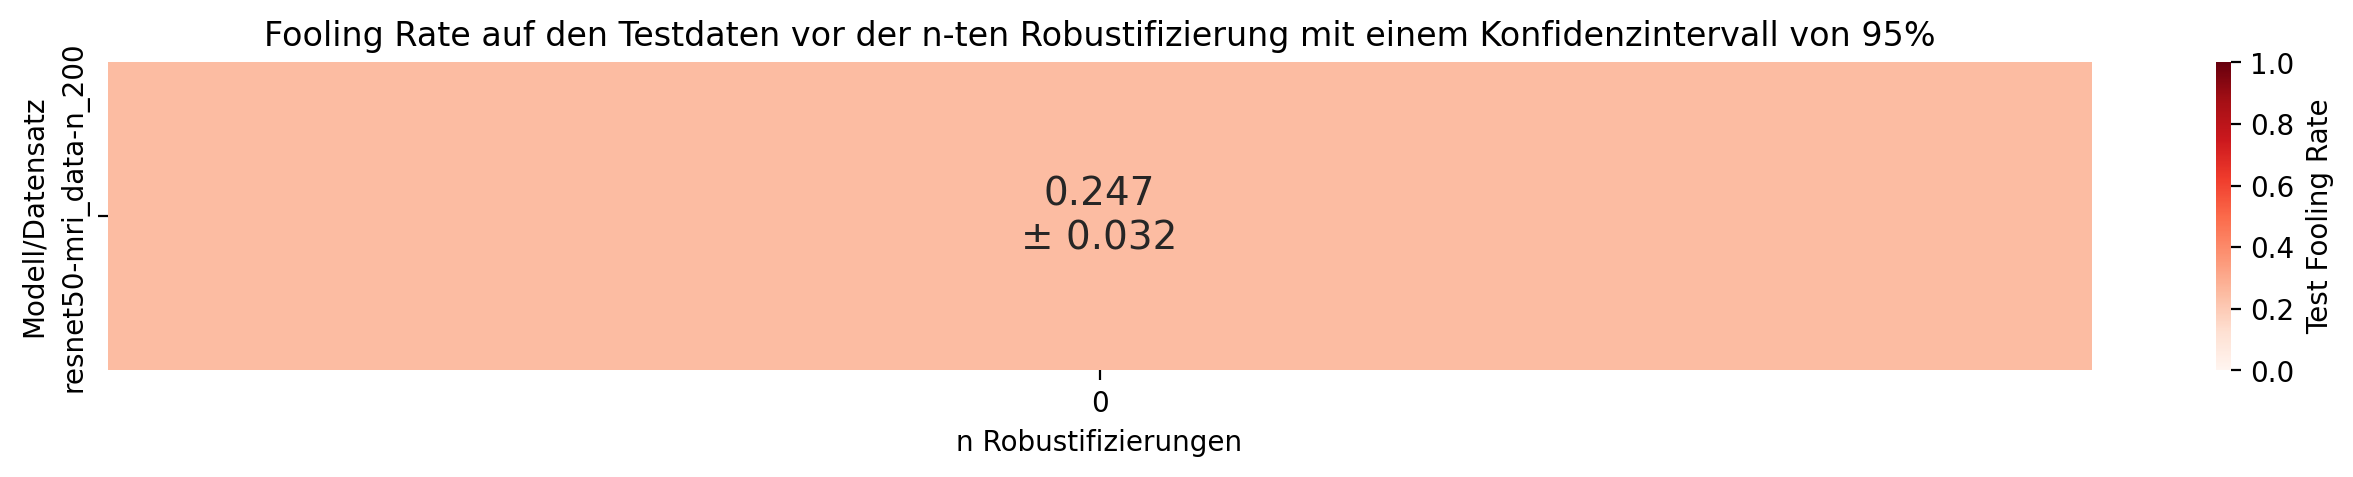

In [5]:
annot = np.empty_like(fooling_rates_unrobustified_mean.values, dtype=object)
for i in range(fooling_rates_unrobustified_mean.shape[0]):
    for j in range(fooling_rates_unrobustified_mean.shape[1]):
        annot[i, j] = f"{fooling_rates_unrobustified_mean.values[i, j]:.3f}\n± {1.96 * fooling_rates_unrobustified_sem.values[i, j]:.3f}"


plt.figure(figsize=(16, 2))

sns.heatmap(
    fooling_rates_unrobustified_mean.astype(float),
    annot=annot,
    fmt="",
    cmap="Reds",
    cbar_kws={"label": "Test Fooling Rate"},
    annot_kws={"size": 14},
    vmin=0,
    vmax=1,
)

plt.xlabel("n Robustifizierungen")
plt.ylabel("Modell/Datensatz")
plt.title("Fooling Rate auf den Testdaten vor der n-ten Robustifizierung mit einem Konfidenzintervall von 95%")
plt.show()

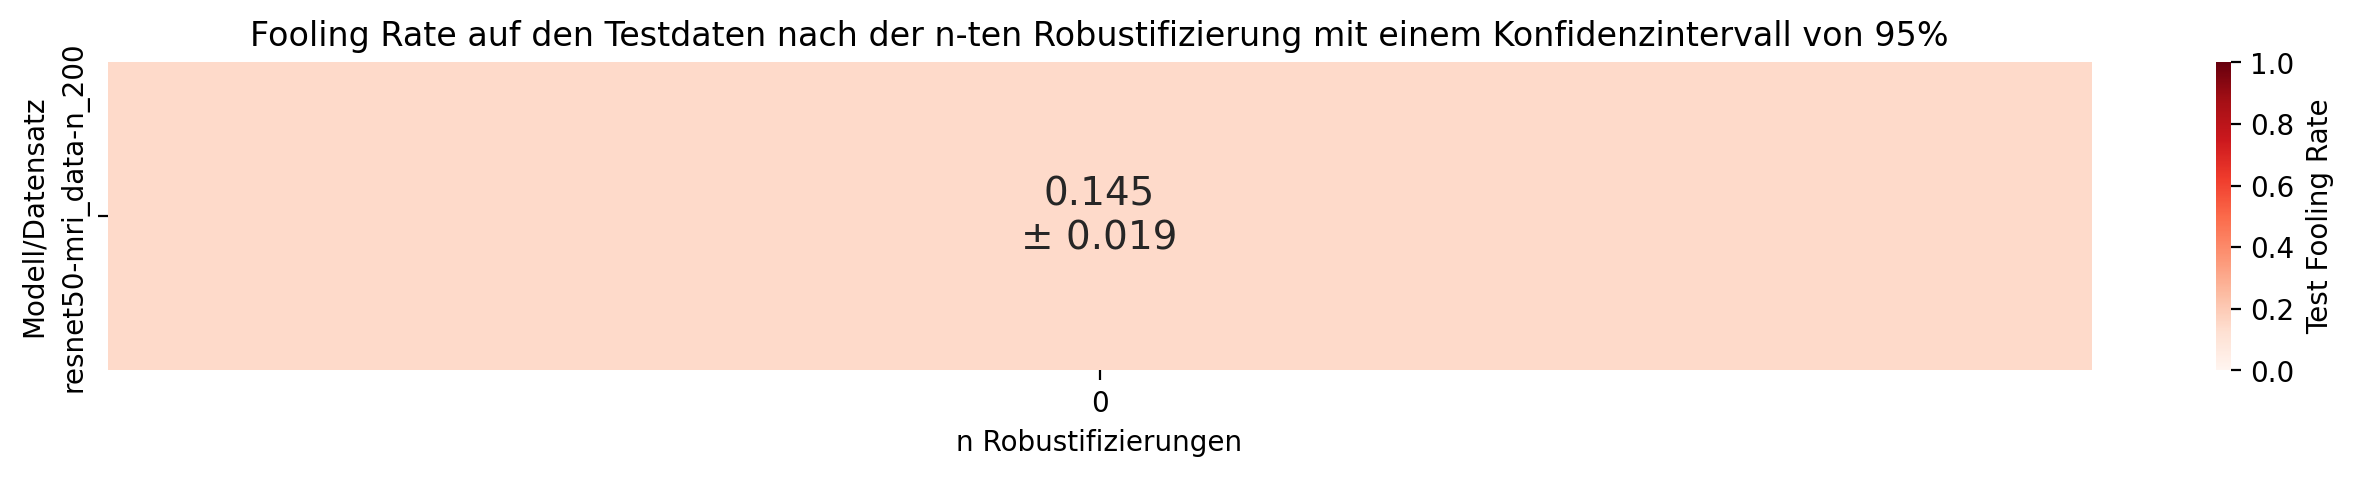

In [6]:
annot = np.empty_like(fooling_rates_robustified_mean.values, dtype=object)
for i in range(fooling_rates_robustified_mean.shape[0]):
    for j in range(fooling_rates_robustified_mean.shape[1]):
        annot[i, j] = (
            f"{fooling_rates_robustified_mean.values[i, j]:.3f}\n± {1.96 * fooling_rates_robustified_sem.values[i, j]:.3f}"
        )

plt.figure(figsize=(16, 2))
sns.heatmap(
    fooling_rates_robustified_mean.astype(float),
    annot=annot,
    fmt="",
    cmap="Reds",
    cbar_kws={"label": "Test Fooling Rate"},
    annot_kws={"size": 14},
    vmin=0,
    vmax=1,
)

plt.xlabel("n Robustifizierungen")
plt.ylabel("Modell/Datensatz")
plt.title("Fooling Rate auf den Testdaten nach der n-ten Robustifizierung mit einem Konfidenzintervall von 95%")
plt.show()

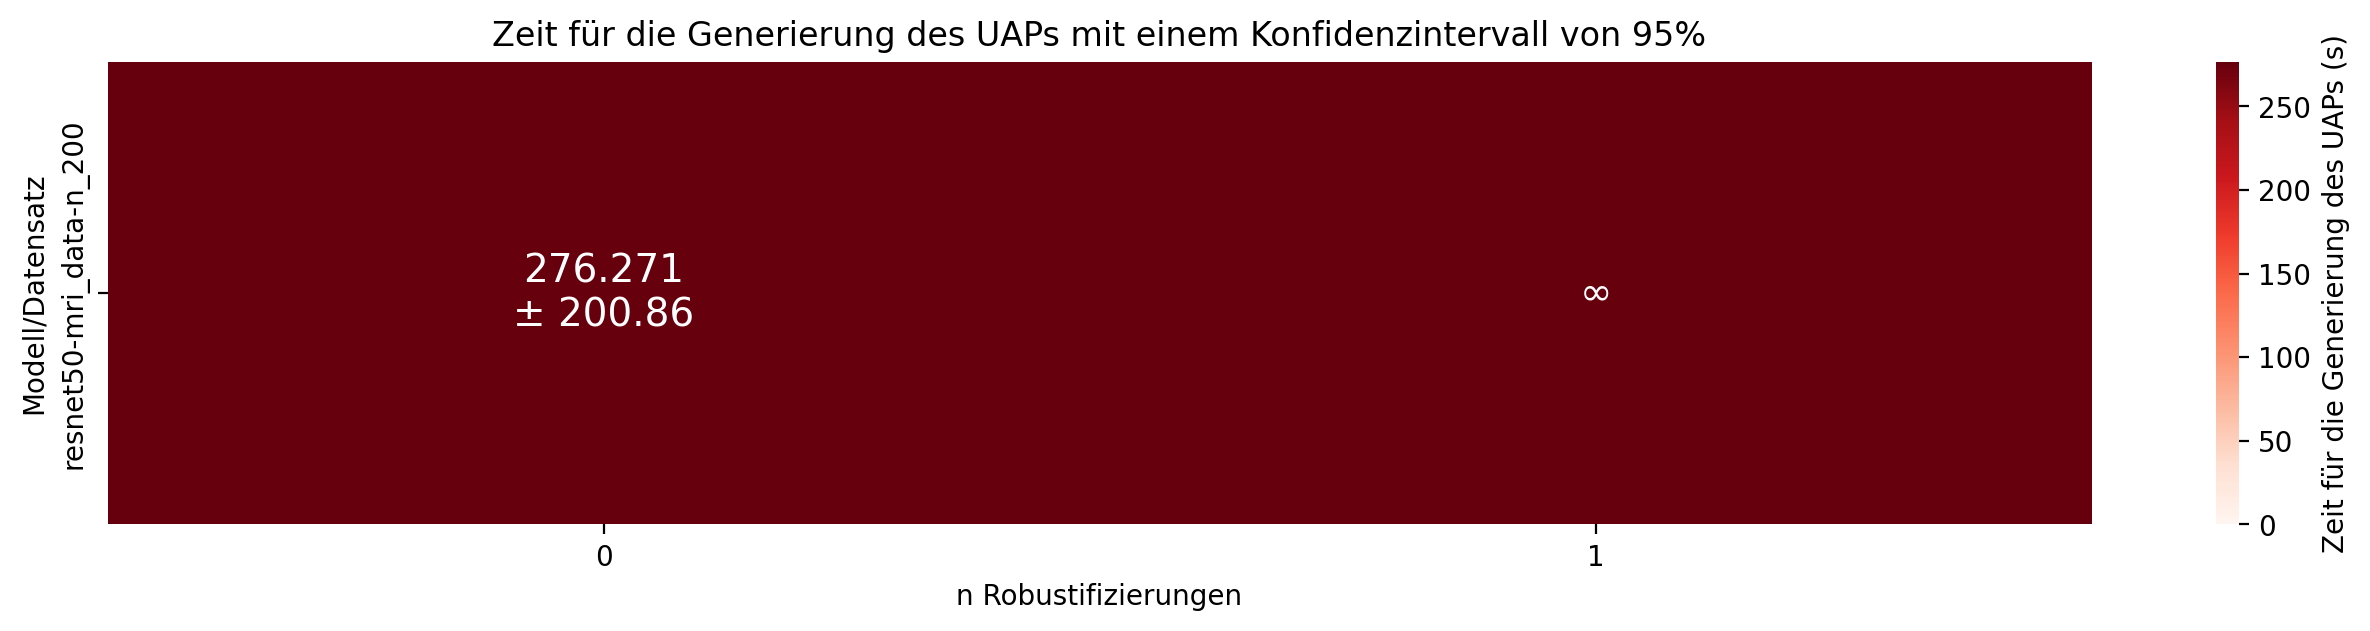

In [7]:
uap_times = df_results[df_results["metric"] == "uap_time_elapsed"].sort_values(
    by=["robustification", "stage"], ascending=True
)
uap_times = uap_times.pivot_table(index="model", columns=["robustification", "agg"], values=["value"])

uap_times_mean = uap_times.xs("mean", axis=1, level=2).droplevel(0, axis=1)
uap_times_sem = uap_times.xs("sem", axis=1, level=2).droplevel(0, axis=1)

annot = np.empty_like(uap_times_mean.values, dtype=object)
for i in range(uap_times_mean.shape[0]):
    for j in range(uap_times_mean.shape[1]):
        if uap_times_mean.values[i, j] == np.inf:
            annot[i, j] = "∞"
        else:
            annot[i, j] = f"{uap_times_mean.values[i, j]:.3f}\n± {1.96 * uap_times_sem.values[i, j]:.2f}"

vmax_value = uap_times_mean.replace(np.inf, np.nan).max().max()

plt.figure(figsize=(16, 3))

sns.heatmap(
    uap_times_mean.astype(float).replace(np.inf, vmax_value),
    annot=annot,
    fmt="",
    cmap="Reds",
    cbar_kws={"label": "Zeit für die Generierung des UAPs (s)"},
    annot_kws={"size": 14},
    vmin=0,
    vmax=vmax_value,
)

plt.xlabel("n Robustifizierungen")
plt.ylabel("Modell/Datensatz")
plt.title("Zeit für die Generierung des UAPs mit einem Konfidenzintervall von 95%")
plt.show()

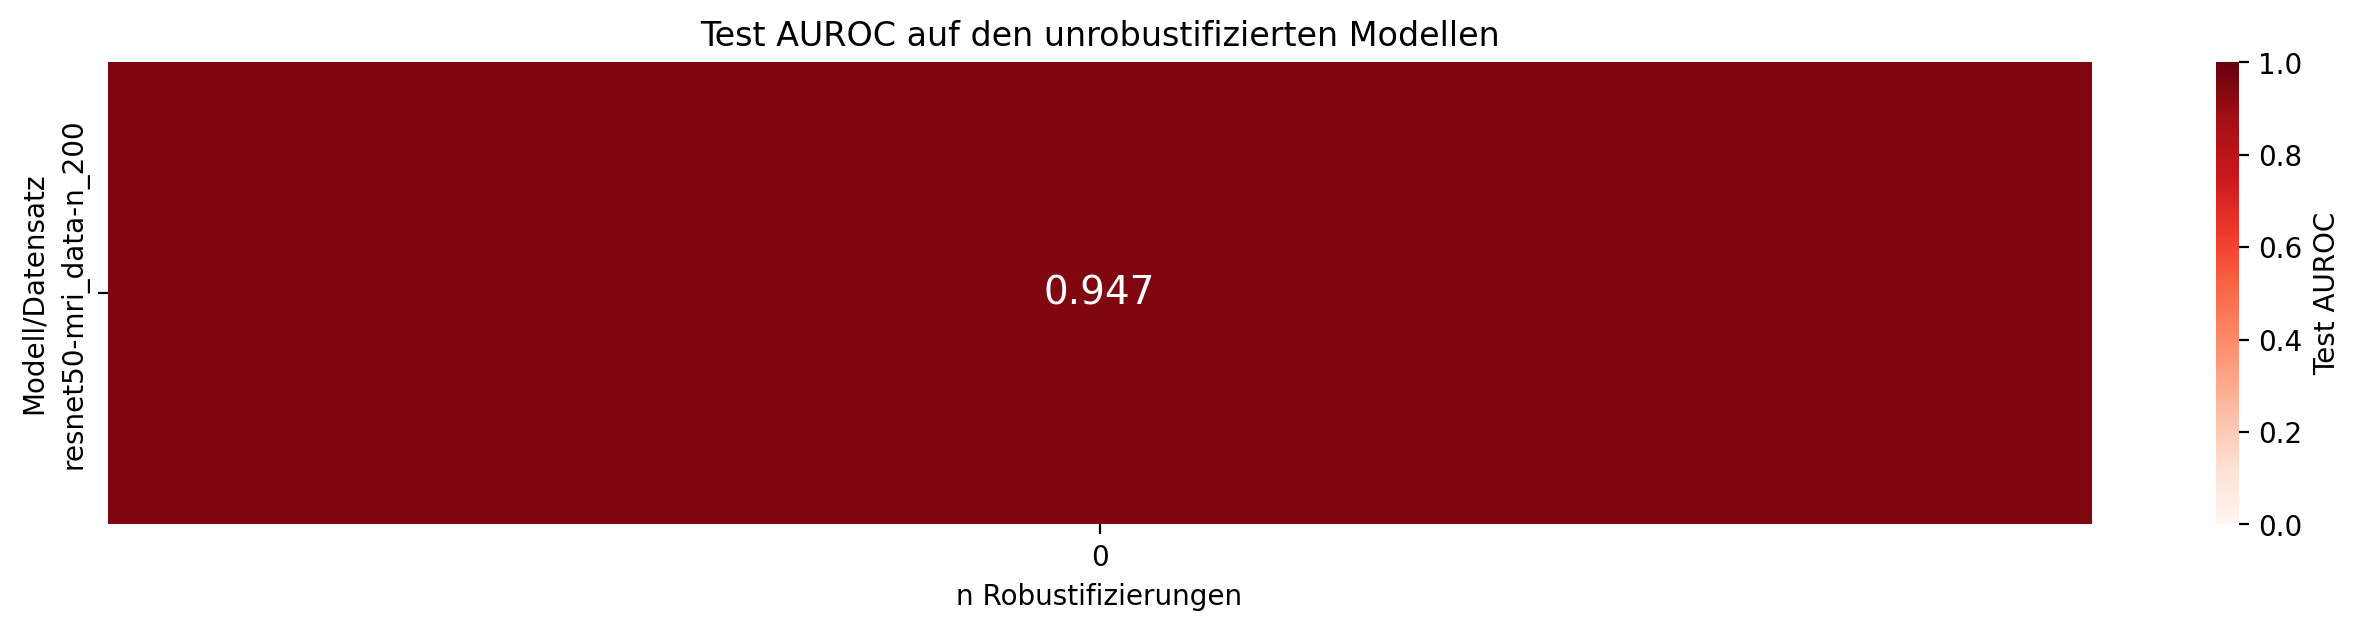

In [8]:
auroc = df_results[(df_results["metric"] == "test_BinaryAUROC") & (df_results["stage"] == "02_eval_unrobustified_test")]
auroc = auroc.pivot_table(index="model", columns=["robustification"], values=["value"]).droplevel(0, axis=1)

plt.figure(figsize=(16, 3))
sns.heatmap(
    auroc.astype(float),
    annot=True,
    fmt=".3f",
    cmap="Reds",
    cbar_kws={"label": "Test AUROC"},
    annot_kws={"size": 14},
    vmin=0,
    vmax=1,
) 
plt.xlabel("n Robustifizierungen")
plt.ylabel("Modell/Datensatz")
plt.title("Test AUROC auf den unrobustifizierten Modellen")
plt.show()